# Random Forest Model - Tabular data

## Dataset

As usual, we begin by reviweing the dataset we are working with.

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("kepler_tess_dataset-2.csv")

df.drop("Unnamed: 0", axis=1, inplace=True)

df.head()



,search_id,num_planet,disposition,ror,stellar_mass,ss_gravity,period,duration,transit_epoch
0,KIC 10797460,1,1,0.022344,0.919,4.467,9.488036,2.95750,2.455004e+06
1,KIC 10797460,2,1,0.027954,0.919,4.467,54.418383,4.50700,2.454996e+06
2,KIC 10811496,1,2,0.154046,0.961,4.544,19.899140,1.78220,2.455009e+06
3,KIC 10848459,1,0,0.387394,0.836,4.564,1.736952,2.40641,2.455003e+06
4,KIC 10854555,1,1,0.024064,1.095,4.438,2.525592,1.65450,2.455005e+06


In [3]:
df.shape

(15752, 9)

In [4]:
df_F = df[df['disposition'] != 2]

df_F.head()


,search_id,num_planet,disposition,ror,stellar_mass,ss_gravity,period,duration,transit_epoch
0,KIC 10797460,1,1,0.022344,0.919,4.467,9.488036,2.95750,2.455004e+06
1,KIC 10797460,2,1,0.027954,0.919,4.467,54.418383,4.50700,2.454996e+06
3,KIC 10848459,1,0,0.387394,0.836,4.564,1.736952,2.40641,2.455003e+06
4,KIC 10854555,1,1,0.024064,1.095,4.438,2.525592,1.65450,2.455005e+06
5,KIC 10872983,1,1,0.036779,1.053,4.486,11.094321,4.59450,2.455004e+06


In [5]:
df_F.shape

(8689, 9)

In [6]:
df_F.value_counts("disposition")

disposition
0    5042
1    3647
Name: count, dtype: int64

# Random Forest training

For the tabular data, we use a simple random forest model trained on both Kepler and TESS datasets

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

### Data splitting

If just split without any caution, signals from the same star may end up in both the train and test datasets, and the model may learn some features based on the star (like having this star is more likely to be an exoplanet, which is nonsense), therefore we split considering ´´´search_id´´´

In [14]:

df = df_F[df_F['disposition'].isin([0, 1])].copy()

feature_cols = ['ror', 'stellar_mass', 'ss_gravity', 'period', 'duration', 'transit_epoch']

X = df[feature_cols]
y = df['disposition'].astype(int)

groups = df['search_id']

# Grouped split ensures all rows from the same search_id stay in the same split
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train = groups.iloc[train_idx]
groups_test  = groups.iloc[test_idx]


# report
print("Shapes:")
print("  X_train:", X_train.shape, " X_test:", X_test.shape)

print("\nClass balance:")
print("  Train:\n", y_train.value_counts(normalize=True).rename({0:'FP %', 1:'Planet %'}))
print("\n  Test:\n",  y_test.value_counts(normalize=True).rename({0:'FP %', 1:'Planet %'}))

# unique stars per split
print("\nUnique stars:")
print("  Train stars:", groups_train.nunique())
print("  Test  stars:", groups_test.nunique())


Shapes:
  X_train: (6983, 6)  X_test: (1706, 6)

Class balance:
  Train:
 disposition
FP %        0.573679
Planet %    0.426321
Name: proportion, dtype: float64

  Test:
 disposition
FP %        0.607268
Planet %    0.392732
Name: proportion, dtype: float64

Unique stars:
  Train stars: 6157
  Test  stars: 1540


In [15]:
# Random Forest training

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=6,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

print("Trained RandomForestClassifier.")


Trained RandomForestClassifier.


### Evaluation metrics

To make sure we our model is not overfitting, we review accuracy, precision, recall, F1, ROC AUC and log loss in both train and test dataset. A balanced model should have similar values and those from the train should be slightly greater than those from the test.


In [19]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, brier_score_loss, confusion_matrix,
    classification_report
)

def _proba_or_decision(model, X):
    """Return positive-class probability if available, else a normalized score for ROC/log-loss."""
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        # Map decision scores to [0,1] with a logistic transform for log_loss/Brier (approximate)
        scores = model.decision_function(X)
        return 1 / (1 + np.exp(-scores))
    else:
        # Fall back to hard predictions (ROC/log-loss won’t be meaningful)
        return model.predict(X).astype(float)

def eval_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\n===== {name} =====")

    # Predictions
    yhat_tr = model.predict(X_train)
    yhat_te = model.predict(X_test)

    # Probabilities / scores for probabilistic metrics
    p_tr = _proba_or_decision(model, X_train)
    p_te = _proba_or_decision(model, X_test)

    # ---- TRAIN ----
    acc_tr  = accuracy_score(y_train, yhat_tr)
    prec_tr = precision_score(y_train, yhat_tr, zero_division=0)
    rec_tr  = recall_score(y_train, yhat_tr, zero_division=0)
    f1_tr   = f1_score(y_train, yhat_tr)
    roc_tr  = roc_auc_score(y_train, p_tr) if len(np.unique(y_train)) == 2 else np.nan
    ll_tr   = log_loss(y_train, np.c_[1-p_tr, p_tr], labels=[0,1])
    br_tr   = brier_score_loss(y_train, p_tr)

    # ---- TEST ----
    acc_te  = accuracy_score(y_test, yhat_te)
    prec_te = precision_score(y_test, yhat_te, zero_division=0)
    rec_te  = recall_score(y_test, yhat_te, zero_division=0)
    f1_te   = f1_score(y_test, yhat_te)
    roc_te  = roc_auc_score(y_test, p_te) if len(np.unique(y_test)) == 2 else np.nan
    ll_te   = log_loss(y_test, np.c_[1-p_te, p_te], labels=[0,1])
    br_te   = brier_score_loss(y_test, p_te)

    # Print summary
    print("\n--- Train ---")
    print(f"Accuracy:  {acc_tr:6.4f}")
    print(f"Precision: {prec_tr:6.4f}")
    print(f"Recall:    {rec_tr:6.4f}")
    print(f"F1-score:  {f1_tr:6.4f}")
    print(f"ROC AUC:   {roc_tr:6.4f}")
    print(f"Log loss:  {ll_tr:6.4f}")
    print(f"Brier:     {br_tr:6.4f}")

    print("\n--- Test ---")
    print(f"Accuracy:  {acc_te:6.4f}")
    print(f"Precision: {prec_te:6.4f}")
    print(f"Recall:    {rec_te:6.4f}")
    print(f"F1-score:  {f1_te:6.4f}")
    print(f"ROC AUC:   {roc_te:6.4f}")
    print(f"Log loss:  {ll_te:6.4f}")
    print(f"Brier:     {br_te:6.4f}")

# Run evaluations
eval_model("RandomForest (rf)", rf, X_train, y_train, X_test, y_test)




===== RandomForest (rf) =====

--- Train ---
Accuracy:  0.8599
Precision: 0.7865
Recall:    0.9217
F1-score:  0.8487
ROC AUC:   0.9268
Log loss:  0.3552
Brier:     0.1098

--- Test ---
Accuracy:  0.8523
Precision: 0.7659
Recall:    0.8985
F1-score:  0.8269
ROC AUC:   0.9225
Log loss:  0.3641
Brier:     0.1131



Confusion matrix (Test) [rows=true, cols=pred]:
[[852 184]
 [ 68 602]]
TN=852, FP=184, FN=68, TP=602


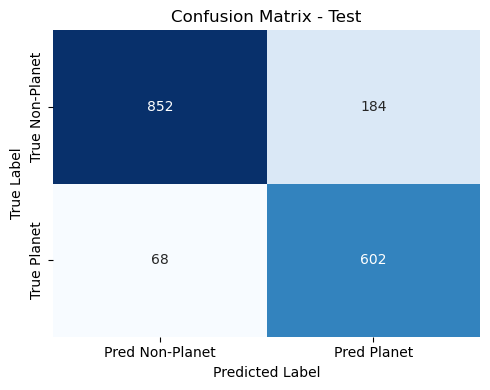

In [18]:
# confusion matrix plot

yhat_te = rf.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, yhat_te, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

print("\nConfusion matrix (Test) [rows=true, cols=pred]:")
print(cm)
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred Non-Planet', 'Pred Planet'],
            yticklabels=['True Non-Planet', 'True Planet'])
plt.title('Confusion Matrix - Test')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


It was found that max_depth has the greatest impact on overfitting; therefore, we sweep over a continuous range of integers to find the one that offers the best balance.

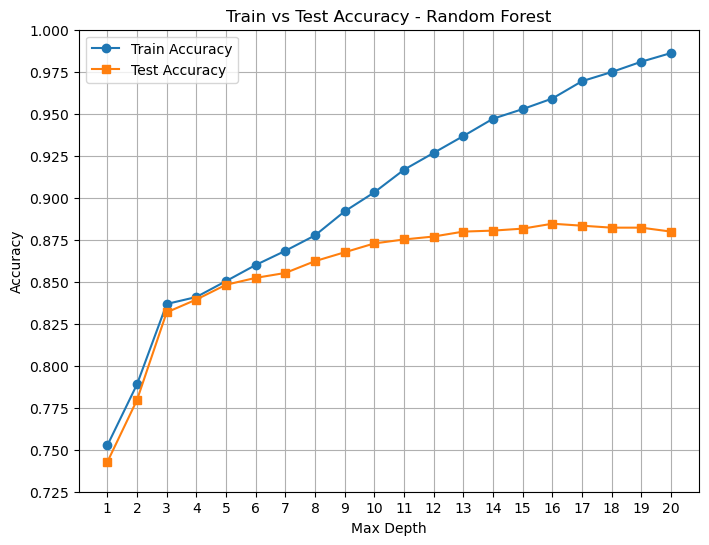

In [23]:
# we sweep over max_depth values

depths = list(range(1, 21)) 
train_acc = []
test_acc = []

for d in depths:
    rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=d,
        min_samples_split=5,
        min_samples_leaf=1,
        max_features="sqrt",
        n_jobs=-1,
        random_state=42
    )
    rf.fit(X_train, y_train)
    
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)
    
    train_acc.append(accuracy_score(y_train, y_pred_train))
    test_acc.append(accuracy_score(y_test, y_pred_test))

# plot
plt.figure(figsize=(8,6))
plt.plot(depths, train_acc, marker="o", label="Train Accuracy")
plt.plot(depths, test_acc, marker="s", label="Test Accuracy")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy - Random Forest")
plt.xticks(depths)
plt.yticks(np.arange(0.725, 1.025, 0.025))
plt.legend()
plt.grid(True)
plt.show()


## Saving Model

In [32]:
import joblib

# Example: assume you already trained rf
#rf.fit(X_train, y_train)

# Save the model
joblib.dump(rf, "random_forest_exoplanets.pkl")
print("Model saved as random_forest_exoplanets.pkl")


Model saved as random_forest_exoplanets.pkl


In [33]:
# Load the model back
rf_loaded = joblib.load("random_forest_exoplanets.pkl")

# Use it for predictions
y_pred = rf_loaded.predict(X_test)
y_proba = rf_loaded.predict_proba(X_test)[:, 1]

print("Loaded model test accuracy:", (y_pred == y_test).mean())


Loaded model test accuracy: 0.8522860492379836
